Speech Emotion Recognition - Complete Experiments
Loading datasets...
CREMA-D files: 7442
RAVDESS files: 2880
Total files: 10322
Extracting features from Combined Dataset...
Processed 500/10322 files
Processed 1000/10322 files
Processed 1500/10322 files
Processed 2000/10322 files
Processed 2500/10322 files
Processed 3000/10322 files
Processed 3500/10322 files
Processed 4000/10322 files
Processed 4500/10322 files
Processed 5000/10322 files
Processed 5500/10322 files
Processed 6000/10322 files
Processed 6500/10322 files
Processed 7000/10322 files
Processed 7500/10322 files
Processed 8000/10322 files
Processed 8500/10322 files
Processed 9000/10322 files
Processed 9500/10322 files
Processed 10000/10322 files
Extracted features from 10322 files
Total feature dimensions: 113

Experiment 1: Combined Dataset 80/20 Split
----------------------------------------
Train samples: 8257, Test samples: 2065
Training Random Forest...
Random Forest - Accuracy: 0.6179, F1: 0.6100
Training SVM...
SVM - Ac

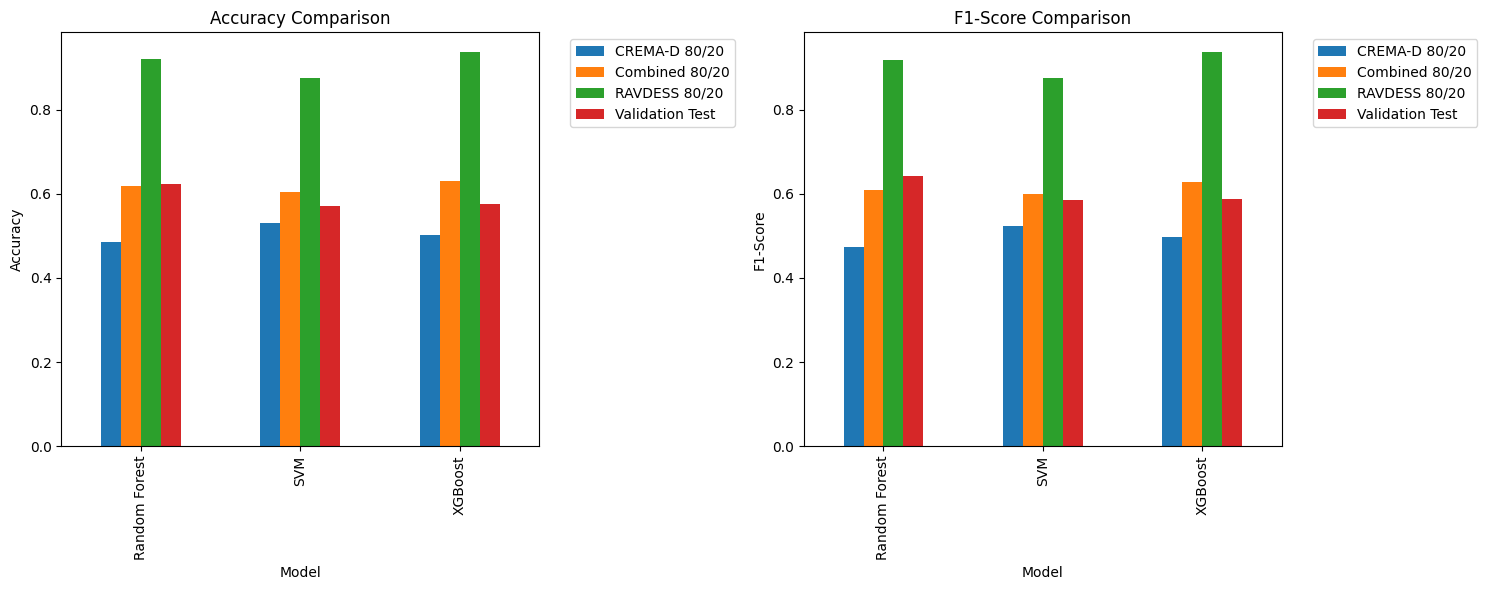


Experiments completed.


In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
np.random.seed(42)
random.seed(42)

print("Speech Emotion Recognition - Complete Experiments")
print("=" * 60)

# ================================
# 1. DATASET LOADING
# ================================

def load_crema_d(base_path):
    """Load CREMA-D dataset information"""
    audio_files = []
    emotion_map = {
        'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear',
        'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
    }
    
    for file in os.listdir(base_path):
        if file.endswith('.wav'):
            parts = file.split('_')
            if len(parts) >= 3 and parts[2] in emotion_map:
                audio_files.append({
                    'filename': file,
                    'filepath': os.path.join(base_path, file),
                    'emotion': emotion_map[parts[2]],
                    'actor_id': parts[0],
                    'dataset': 'CREMA-D'
                })
    return audio_files

def load_ravdess(base_path):
    """Load RAVDESS dataset information"""
    audio_files = []
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
    }
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.wav') and file.startswith('03-01-'):
                parts = file.split('-')
                if len(parts) >= 7 and parts[2] in emotion_map:
                    emotion = emotion_map[parts[2]]
                    if emotion == 'calm':
                        emotion = 'neutral'
                    
                    audio_files.append({
                        'filename': file,
                        'filepath': os.path.join(root, file),
                        'emotion': emotion,
                        'actor_id': f"R{parts[6].split('.')[0]}",
                        'dataset': 'RAVDESS'
                    })
    return audio_files

print("Loading datasets...")
crema_files = load_crema_d('/kaggle/input/cremad/AudioWAV')
ravdess_files = load_ravdess('/kaggle/input/ravdess-emotional-speech-audio')
all_files = crema_files + ravdess_files

print(f"CREMA-D files: {len(crema_files)}")
print(f"RAVDESS files: {len(ravdess_files)}")
print(f"Total files: {len(all_files)}")

# ================================
# 2. AUDIO PREPROCESSING
# ================================

TARGET_SR = 16000
TARGET_DURATION = 3.0

def normalize_audio_duration(audio, sr, target_duration=3.0):
    target_length = int(target_duration * sr)
    if len(audio) > target_length:
        start = (len(audio) - target_length) // 2
        audio = audio[start:start + target_length]
    elif len(audio) < target_length:
        pad_length = target_length - len(audio)
        audio = np.pad(audio, (0, pad_length), mode='constant', constant_values=0)
    return audio

def apply_loudness_normalization(audio):
    rms = np.sqrt(np.mean(audio**2))
    if rms > 0:
        target_rms = 0.1
        scale_factor = target_rms / rms
        audio = audio * scale_factor
    
    max_val = np.max(np.abs(audio))
    if max_val > 0.95:
        audio = audio * (0.95 / max_val)
    return audio

# ================================
# 3. FEATURE EXTRACTION
# ================================

def extract_audio_features(filepath):
    """Extract comprehensive features from audio file"""
    try:
        # Load and preprocess audio
        audio, orig_sr = librosa.load(filepath, sr=None)
        if orig_sr != TARGET_SR:
            audio = librosa.resample(audio, orig_sr=orig_sr, target_sr=TARGET_SR)
        
        audio = normalize_audio_duration(audio, TARGET_SR, TARGET_DURATION)
        audio = apply_loudness_normalization(audio)
        
        features = {}
        
        # MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=TARGET_SR, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        for i in range(13):
            features[f'mfcc_{i}_mean'] = np.mean(mfcc[i])
            features[f'mfcc_{i}_std'] = np.std(mfcc[i])
            features[f'mfcc_{i}_delta_mean'] = np.mean(mfcc_delta[i])
            features[f'mfcc_{i}_delta_std'] = np.std(mfcc_delta[i])
            features[f'mfcc_{i}_delta2_mean'] = np.mean(mfcc_delta2[i])
            features[f'mfcc_{i}_delta2_std'] = np.std(mfcc_delta2[i])
        
        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=TARGET_SR)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=TARGET_SR)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=TARGET_SR)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
        
        features.update({
            'spectral_centroid_mean': np.mean(spectral_centroids),
            'spectral_centroid_std': np.std(spectral_centroids),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_rolloff_std': np.std(spectral_rolloff),
            'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
            'spectral_bandwidth_std': np.std(spectral_bandwidth),
            'zcr_mean': np.mean(zero_crossing_rate),
            'zcr_std': np.std(zero_crossing_rate)
        })
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=TARGET_SR)
        for i in range(12):
            features[f'chroma_{i}_mean'] = np.mean(chroma[i])
            features[f'chroma_{i}_std'] = np.std(chroma[i])
        
        # Temporal features
        try:
            tempo, _ = librosa.beat.beat_track(y=audio, sr=TARGET_SR)
            if isinstance(tempo, (list, np.ndarray)):
                tempo = float(tempo[0]) if len(tempo) > 0 else 120.0
            else:
                tempo = float(tempo) if not np.isnan(tempo) else 120.0
        except:
            tempo = 120.0
        features['tempo'] = tempo
        
        # Energy features
        rms = librosa.feature.rms(y=audio)[0]
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)
        
        return features
        
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
        return None

def extract_features_from_dataset(file_list, dataset_name):
    """Extract features from a list of files"""
    print(f"Extracting features from {dataset_name}...")
    
    features_list = []
    labels_list = []
    metadata_list = []
    
    for idx, file_info in enumerate(file_list):
        if (idx + 1) % 500 == 0:
            print(f"Processed {idx + 1}/{len(file_list)} files")
        
        features = extract_audio_features(file_info['filepath'])
        if features is not None:
            features_list.append(features)
            labels_list.append(file_info['emotion'])
            metadata_list.append({
                'filename': file_info['filename'],
                'dataset': file_info['dataset'],
                'actor_id': file_info['actor_id'],
                'emotion': file_info['emotion']
            })
    
    # Convert to DataFrame and ensure numeric features
    features_df = pd.DataFrame(features_list)
    for col in features_df.columns:
        if features_df[col].dtype == 'object':
            features_df[col] = pd.to_numeric(features_df[col], errors='coerce').fillna(0.0)
    
    features_df['emotion'] = labels_list
    metadata_df = pd.DataFrame(metadata_list)
    features_df = pd.concat([features_df, metadata_df[['filename', 'dataset', 'actor_id']]], axis=1)
    
    print(f"Extracted features from {len(features_df)} files")
    return features_df

# Extract features from all data
combined_features = extract_features_from_dataset(all_files, "Combined Dataset")
feature_columns = [col for col in combined_features.columns if col not in ['emotion', 'filename', 'dataset', 'actor_id']]

print(f"Total feature dimensions: {len(feature_columns)}")

# ================================
# 4. EXPERIMENT 1: COMBINED DATASET 80/20
# ================================

print("\nExperiment 1: Combined Dataset 80/20 Split")
print("-" * 40)

# Prepare data
X = combined_features[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0.0)
y = combined_features['emotion']

# Label encoding for XGBoost
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encode labels after splitting to maintain correspondence
y_train_enc = label_encoder.transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# Train models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
}

combined_results = {}
trained_models = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    if model_name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    elif model_name == 'XGBoost':
        model.fit(X_train, y_train_enc)
        y_pred_enc = model.predict(X_test)
        y_pred = label_encoder.inverse_transform(y_pred_enc)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    combined_results[model_name] = {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1
    }
    trained_models[model_name] = model
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# ================================
# 5. EXPERIMENT 2: CREMA-D ONLY 80/20
# ================================

print("\nExperiment 2: CREMA-D Only 80/20 Split")
print("-" * 40)

crema_features = combined_features[combined_features['dataset'] == 'CREMA-D'].copy()
X_crema = crema_features[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0.0)
y_crema = crema_features['emotion']
y_crema_encoded = label_encoder.transform(y_crema)

print(f"CREMA-D samples: {len(crema_features)}")

if y_crema.value_counts().min() >= 2:
    X_crema_train, X_crema_test, y_crema_train, y_crema_test = train_test_split(
        X_crema, y_crema, test_size=0.2, random_state=42, stratify=y_crema)
    y_crema_train_enc, y_crema_test_enc = train_test_split(
        y_crema_encoded, test_size=0.2, random_state=42, stratify=y_crema_encoded)
    
    crema_scaler = StandardScaler()
    X_crema_train_scaled = crema_scaler.fit_transform(X_crema_train)
    X_crema_test_scaled = crema_scaler.transform(X_crema_test)
    
    crema_results = {}
    
    for model_name, model_class in [('Random Forest', RandomForestClassifier), 
                                    ('SVM', SVC), ('XGBoost', xgb.XGBClassifier)]:
        if model_name == 'Random Forest':
            model = model_class(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
        elif model_name == 'SVM':
            model = model_class(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        else:
            model = model_class(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
        
        if model_name == 'SVM':
            model.fit(X_crema_train_scaled, y_crema_train)
            y_pred = model.predict(X_crema_test_scaled)
        elif model_name == 'XGBoost':
            model.fit(X_crema_train, y_crema_train_enc)
            y_pred_enc = model.predict(X_crema_test)
            y_pred = label_encoder.inverse_transform(y_pred_enc)
        else:
            model.fit(X_crema_train, y_crema_train)
            y_pred = model.predict(X_crema_test)
        
        accuracy = accuracy_score(y_crema_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_crema_test, y_pred, average='weighted')
        
        crema_results[model_name] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1
        }
        
        print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
else:
    print("Insufficient samples for stratified split")
    crema_results = {}

# ================================
# 6. EXPERIMENT 3: RAVDESS ONLY 80/20
# ================================

print("\nExperiment 3: RAVDESS Only 80/20 Split")
print("-" * 40)

ravdess_features = combined_features[combined_features['dataset'] == 'RAVDESS'].copy()
X_ravdess = ravdess_features[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0.0)
y_ravdess = ravdess_features['emotion']
y_ravdess_encoded = label_encoder.transform(y_ravdess)

print(f"RAVDESS samples: {len(ravdess_features)}")

if y_ravdess.value_counts().min() >= 2:
    X_ravdess_train, X_ravdess_test, y_ravdess_train, y_ravdess_test = train_test_split(
        X_ravdess, y_ravdess, test_size=0.2, random_state=42, stratify=y_ravdess)
    y_ravdess_train_enc, y_ravdess_test_enc = train_test_split(
        y_ravdess_encoded, test_size=0.2, random_state=42, stratify=y_ravdess_encoded)
    
    ravdess_scaler = StandardScaler()
    X_ravdess_train_scaled = ravdess_scaler.fit_transform(X_ravdess_train)
    X_ravdess_test_scaled = ravdess_scaler.transform(X_ravdess_test)
    
    ravdess_results = {}
    
    for model_name, model_class in [('Random Forest', RandomForestClassifier), 
                                    ('SVM', SVC), ('XGBoost', xgb.XGBClassifier)]:
        if model_name == 'Random Forest':
            model = model_class(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
        elif model_name == 'SVM':
            model = model_class(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        else:
            model = model_class(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
        
        if model_name == 'SVM':
            model.fit(X_ravdess_train_scaled, y_ravdess_train)
            y_pred = model.predict(X_ravdess_test_scaled)
        elif model_name == 'XGBoost':
            model.fit(X_ravdess_train, y_ravdess_train_enc)
            y_pred_enc = model.predict(X_ravdess_test)
            y_pred = label_encoder.inverse_transform(y_pred_enc)
        else:
            model.fit(X_ravdess_train, y_ravdess_train)
            y_pred = model.predict(X_ravdess_test)
        
        accuracy = accuracy_score(y_ravdess_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_ravdess_test, y_pred, average='weighted')
        
        ravdess_results[model_name] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1
        }
        
        print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
else:
    print("Insufficient samples for stratified split")
    ravdess_results = {}

# ================================
# 7. VALIDATION DATASET TESTING
# ================================

print("\nExperiment 4: Validation Dataset Testing")
print("-" * 40)

# Load validation dataset
validation_csv_path ="/kaggle/input/perturbed-ser/validation_labels.csv"
validation_audio_dir = "/kaggle/input/perturbed-ser/audio_files"

try:
    validation_df = pd.read_csv(validation_csv_path)
    print(f"Loaded validation dataset: {len(validation_df)} samples")
    
    # Extract validation features
    validation_files = []
    for _, row in validation_df.iterrows():
        validation_files.append({
            'filepath': os.path.join(validation_audio_dir, row['filename']),
            'emotion': row['emotion_label'],
            'filename': row['filename'],
            'dataset': row['original_dataset'],
            'actor_id': row['actor_id']
        })
    
    validation_features = extract_features_from_dataset(validation_files, "Validation Dataset")
    
    # Test models on validation data
    X_val = validation_features[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    y_val = validation_features['emotion']
    X_val_scaled = scaler.transform(X_val)
    
    validation_results = {}
    
    for model_name, model in trained_models.items():
        print(f"Testing {model_name} on validation dataset...")
        
        if model_name == 'SVM':
            y_pred = model.predict(X_val_scaled)
        elif model_name == 'XGBoost':
            y_pred_enc = model.predict(X_val)
            y_pred = label_encoder.inverse_transform(y_pred_enc)
        else:
            y_pred = model.predict(X_val)
        
        accuracy = accuracy_score(y_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
        
        validation_results[model_name] = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1
        }
        
        print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

except Exception as e:
    print(f"Could not load validation dataset: {e}")
    validation_results = {}

# ================================
# 8. RESULTS SUMMARY
# ================================

print("\nResults Summary")
print("=" * 60)

all_results = []

# Combined results
for model, metrics in combined_results.items():
    all_results.append({
        'Experiment': 'Combined 80/20',
        'Model': model,
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1']
    })

# CREMA-D results
for model, metrics in crema_results.items():
    all_results.append({
        'Experiment': 'CREMA-D 80/20',
        'Model': model,
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1']
    })

# RAVDESS results
for model, metrics in ravdess_results.items():
    all_results.append({
        'Experiment': 'RAVDESS 80/20',
        'Model': model,
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1']
    })

# Validation results
for model, metrics in validation_results.items():
    all_results.append({
        'Experiment': 'Validation Test',
        'Model': model,
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1']
    })

results_df = pd.DataFrame(all_results)
print(results_df.round(4))

# Visualization
if len(all_results) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    pivot_acc = results_df.pivot(index='Model', columns='Experiment', values='Accuracy')
    pivot_acc.plot(kind='bar', ax=ax1, title='Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # F1-Score comparison
    pivot_f1 = results_df.pivot(index='Model', columns='Experiment', values='F1-Score')
    pivot_f1.plot(kind='bar', ax=ax2, title='F1-Score Comparison')
    ax2.set_ylabel('F1-Score')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

print("\nExperiments completed.")